# Project: state-of-the-union speeches

In this project, we will load and process the `us_president_speeches.csv` file, preprocess the speeches, embed their words and do topic modeling on them.

In [77]:
import warnings; 
warnings.simplefilter('ignore')

## Preamble

In [78]:
!pip install --upgrade gensim

You should consider upgrading via the '/usr/local/anaconda3/envs/AI_ITU/bin/python -m pip install --upgrade pip' command.


In [79]:
!pip install pyldavis

You should consider upgrading via the '/usr/local/anaconda3/envs/AI_ITU/bin/python -m pip install --upgrade pip' command.


In [80]:


from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download("wordnet")
nltk.download("stopwords")
from nltk import WordNetLemmatizer

from wordcloud import WordCloud

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, KeyedVectors, LdaMulticore
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package wordnet to /Users/jvang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jvang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading up the data

### Exercise 1

Load up the `us_president_speeches.csv` into an array named `speeches` and print the first 5 rows.

In [81]:
speeches = pd.read_csv("/Users/jvang/Documents/Projects/Applied_AI_IT_Uni/day06/us_president_speeches.csv")

speeches.head()

,president,year,speech
0,Washington,1791,Fellow-Citizens of the Senate and House of Rep...
1,Washington,1792,Fellow-Citizens of the Senate and House of Rep...
2,Washington,1793,Fellow-Citizens of the Senate and House of Rep...
3,Washington,1794,Fellow-Citizens of the Senate and House of Rep...
4,Washington,1795,Fellow-Citizens of the Senate and House of Rep...


### Exercise 2

Fill in the `???`s.

1. How many speeches are in the DataFrame?
2. How many unique presidents are in the DataFrame?
3. What's the longest speech? How long is it (in characters)? Who gave it and when?

In [82]:
print("Nr. Speeches", len(speeches["speech"].unique()))
print("Nr. Presidents", len(speeches["president"].unique()))

print("Longest speech is at index:", speeches.index[speeches["speech"] == speeches["speech"].max()][0])
length = len(speeches["speech"][189])
print(f"It is {length} characters long.")

president = speeches["president"][189]
year = speeches["year"][189]
print(f"President {president} gave it in {year}")

Nr. Speeches 227
Nr. Presidents 38
Longest speech is at index: 186
It is 217947 characters long.
President Carter gave it in 1981


Expected solution:
```
Nr. Speeches 227
Nr. Presidents 38
Longest speech is at index: 189
It is 217947 characters long.
President Carter gave it in 1981
```

## Preprocessing the data

### Exercise 3

In this exercise we will write a function that cleans the column `speech` of the dataframe, and returns a corpus of type `List[List[str]]`. Include `"wa", "ha"` in your list of stopwords.

In [83]:
def clean_speech(df: pd.DataFrame) -> List[List[str]]:
  # Get the column
  texts = df["speech"]

  # Clean newlines (\n)
  texts = texts.map(lambda x: x.replace("\n", " "))

  # Apply simple_preprocess from gensim
  texts = [simple_preprocess(t) for t in texts]

  # Lemmatize using WordNetLemmatizer
  lemmatizer = WordNetLemmatizer()
  texts = [
    [lemmatizer.lemmatize(token) for token in doc] for doc in texts
  ]

  # Remove stopwords
  english_stopwords = set(nltk.corpus.stopwords.words("english"))
  english_stopwords.add("wa")
  english_stopwords.add("ha")
  texts = [
      [word for word in doc if word not in english_stopwords] for doc in texts
    ]

  return texts

Define a variable `corpus` with the result of applying this function to our `speeches` df.

In [84]:
corpus = clean_speech(speeches)

In [85]:
print(len(corpus))

227


### Exercise 4

Print the first 50 characters speech alongside the first 10 words of its corresponding `List[str]` inside corpus. Check that both match in a meaningful way.

In [86]:
print(speeches["speech"][0][:50])
print(corpus[0][:10])

Fellow-Citizens of the Senate and House of Represe
['fellow', 'citizen', 'senate', 'house', 'representative', 'vain', 'may', 'expect', 'peace', 'indian']


Expected answer:

```
Fellow-Citizens of the Senate and House of Represe
['fellow', 'citizen', 'senate', 'house', 'representative', 'vain', 'may', 'expect', 'peace', 'indian']
```

### Exercise 5

Define a `Dictionary` on this corpus and call it `dct`. How many unique tokens are there?

In [87]:
dct = Dictionary(corpus)

In [88]:
print(len(dct.keys()))

20030


Expected answer: 73277 unique tokens.

## Embedding words

### Exercise 6

Train a `word2vec` model using `gensim`'s `Word2Vec`. Call it `model_w2v`. Leave all the hyperparameters as the default ones.

In [89]:
model_w2v = Word2Vec(corpus)

### Exercise 7

What's the most similar word to `woman` according to the model? What about `senate`?

In [90]:
model_w2v.wv.most_similar("woman")

[('men', 0.9155260920524597),
 ('young', 0.8875002264976501),
 ('brave', 0.8430379629135132),
 ('trained', 0.8243035078048706),
 ('bodied', 0.7938663363456726),
 ('man', 0.7849280834197998),
 ('scholar', 0.7822882533073425),
 ('child', 0.7788426876068115),
 ('soldier', 0.7782680988311768),
 ('hispanic', 0.7700486183166504)]

In [91]:
model_w2v.wv.most_similar("senate")

[('advice', 0.9621333479881287),
 ('gentleman', 0.9472230672836304),
 ('madison', 0.9008060097694397),
 ('approval', 0.8967880010604858),
 ('consent', 0.8920758366584778),
 ('awaiting', 0.8911767601966858),
 ('greeting', 0.8904749155044556),
 ('senator', 0.8864282369613647),
 ('resolution', 0.8861778974533081),
 ('proposition', 0.8841639161109924)]

## Getting topics

### Exercise 8

Define a `bows` variable with the result of applying `dct.doc2bow` to all documents in `corpus`.

In [92]:
bows =[dct.doc2bow(doc) for doc in corpus]

### Exercise 9

Fit a Latent Dirichlet Allocation to our bags-of-words `bows` using `gensim`'s `LdaMulticore` for 5, 10, 15 and 20 topics. To get comparable results, set the `random_state` to my favorite number, 42.

In [72]:
lda5 = lda_model = LdaMulticore(
    bows,
    id2word=dct,
    num_topics=5,
    random_state=42,
    chunksize=100,
    passes=10,
    per_word_topics=True)

lda10 = lda_model = LdaMulticore(
    bows,
    id2word=dct,
    num_topics=10,
    random_state=42,
    chunksize=100,
    passes=10,
    per_word_topics=True)

lda15 = lda_model = LdaMulticore(
    bows,
    id2word=dct,
    num_topics=15,
    random_state=42,
    chunksize=100,
    passes=10,
    per_word_topics=True)

lda20 = lda_model = LdaMulticore(
    bows,
    id2word=dct,
    num_topics=20,
    random_state=42,
    chunksize=100,
    passes=10,
    per_word_topics=True)

### Exercise 10

Plot a line with number of topics (5, 10, 15 and 20) in the x axis, and log-perplexity of the model in the y axis. Interpret it. What does the log-perplexity usually say?

In [73]:
print("5: ", lda5.log_perplexity(bows), "\n10: ", lda10.log_perplexity(bows), "\n15: ", lda15.log_perplexity(bows), "\n20: ", lda20.log_perplexity(bows))

5:  -7.857931447258422 
10:  -7.893089490978702 
15:  -7.962817046441519 
20:  -8.033435696627343


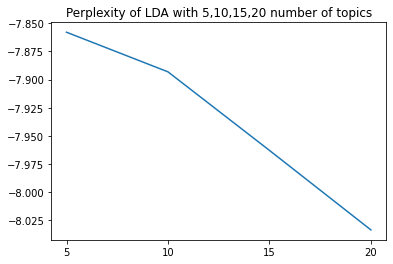

In [74]:
x = [5,10,15,20]
y = [lda5.log_perplexity(bows), lda10.log_perplexity(bows), 
     lda15.log_perplexity(bows), lda20.log_perplexity(bows)]

plt.plot(x, y)
plt.xticks(x)
plt.title("Perplexity of LDA with 5,10,15,20 number of topics")
plt.show()

### Exercise 11

Use `gensimvis` to visualize the model with 20 topics. (The result might be lackluster, why?)

In [75]:
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda20, bows, dct)

In [76]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.108084 -0.064760       1        1  23.266653
12     0.063329  0.199755       2        1  16.505296
17     0.090276  0.108380       3        1  15.248050
18     0.110862 -0.045453       4        1  13.035471
13     0.107622  0.030864       5        1  10.419959
5      0.118823 -0.021810       6        1   8.575661
9      0.113334 -0.044395       7        1   7.947518
16     0.113176 -0.069873       8        1   3.733695
2      0.047822 -0.056340       9        1   0.849495
7     -0.003158  0.032769      10        1   0.289721
11    -0.051721 -0.038500      11        1   0.115624
14    -0.054384 -0.001555      12        1   0.002270
0     -0.078025 -0.005094      13        1   0.001323
15    -0.142532 -0.011514      14        1   0.001323
10    -0.118262  0.012168      15        1   0.001323
1     -0.065478  0.010254      16        1   0.001323
8     -0.030761 -0.020296      17        1   0.001323
4     -0.115070 -0.003937      18        1   0.001323
3     -0.087536  0.004680      19        1   0.001323
19    -0.126402 -0.015344      20        1   0.001323, topic_info=           Term         Freq        Total Category  logprob  loglift
574       state  8583.000000  8583.000000  Default  30.0000  30.0000
272  government  7907.000000  7907.000000  Default  29.0000  29.0000
659        year  6293.000000  6293.000000  Default  28.0000  28.0000
619      united  4788.000000  4788.000000  Default  27.0000  27.0000
119    congress  4986.000000  4986.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
410         one     0.009355  2901.761054  Topic20  -7.1091  -1.4123
381        must     0.009375  3215.701486  Topic20  -7.1068  -1.5128
582     subject     0.007789  1757.252612  Topic20  -7.2922  -1.0939
449       power     0.008570  2877.836058  Topic20  -7.1967  -1.4917
215       every     0.007951  2218.133054  Topic20  -7.2717  -1.3063

[1635 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
10078      6  0.850033        abhors
3370       1  0.857570       acceded
3370       4  0.045135       acceded
3370       5  0.045135       acceded
12594      9  0.776287  accentuating
...      ...       ...           ...
659       11  0.000795          year
15958      2  0.963491           yes
15958      3  0.016612           yes
14895      4  0.922303        zelaya
9906       4  0.892906       zuloaga

[3568 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 13, 18, 19, 14, 6, 10, 17, 3, 8, 12, 15, 1, 16, 11, 2, 9, 5, 4, 20])